In [1]:
from data_loader import load_data
from naive_bayes import BernoulliNaiveBayes
from nlp_processing import LemmaCountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.decomposition import PCA

import time
import pandas as pd
from scipy import stats
from scipy.stats import randint, norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import re
# # taken from https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
# REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
# REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# def preprocess_reviews(reviews):
#     reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
#     reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
#     return "".join(reviews)

# Load Data

In [2]:
# read data
train, test = load_data()
# full_text = list(train.iloc[:, 1].values) + list(test.iloc[:, 1].values)
# raw training and test data
X_train = train.iloc[:,1].values
X_test = test.iloc[:,1].values
y = train.iloc[:,2].values.astype(int)

"Train(X-%s, y-%s), Test(X-%s)"%(X_train.shape, y.shape, X_test.shape)

'Train(X-(25000,), y-(25000,)), Test(X-(25000,))'

# Data Exploration
Are most ocurrent words important?

In [3]:
vect = LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                stem=True, ngram_range=(1, 1))
data = vect.fit_transform(X_train)
counts = np.ravel(data.sum(axis=0))
idx_sort = np.argsort(counts)
words = vect.get_feature_names()
top = 10
["{}:{}".format(w,c) for c,w in zip(counts[idx_sort][-top:], words[-top:])]

['œmad:73265',
 'œmr:75997',
 'œolivera:93975',
 'œoom:96408',
 'œpirates:101871',
 'œplayboya:107328',
 'œsanatoriuma:135722',
 'œthe:145862',
 'œxa:164135',
 'œyoua:336738']

In [6]:
idx = np.argwhere(counts==3)
["{}:{}".format(w,c) for c,w in zip(counts[idx], np.array(words)[idx])]

["['001']:[3]",
 "['10pm']:[3]",
 "['10x']:[3]",
 "['123']:[3]",
 "['125']:[3]",
 "['128']:[3]",
 "['131']:[3]",
 "['134']:[3]",
 "['136']:[3]",
 "['147']:[3]",
 "['1500']:[3]",
 "['15s']:[3]",
 "['1780s']:[3]",
 "['1798']:[3]",
 "['1820']:[3]",
 "['1824']:[3]",
 "['183']:[3]",
 "['1836']:[3]",
 "['1837']:[3]",
 "['1839']:[3]",
 "['1846']:[3]",
 "['1847']:[3]",
 "['1850']:[3]",
 "['1850s']:[3]",
 "['1853']:[3]",
 "['1863']:[3]",
 "['1865']:[3]",
 "['1881']:[3]",
 "['1888']:[3]",
 "['1892']:[3]",
 "['18a']:[3]",
 "['1903']:[3]",
 "['1911']:[3]",
 "['1a']:[3]",
 "['1h']:[3]",
 "['2012']:[3]",
 "['2200']:[3]",
 "['232']:[3]",
 "['24th']:[3]",
 "['2600']:[3]",
 "['26th']:[3]",
 "['270']:[3]",
 "['275']:[3]",
 "['27th']:[3]",
 "['28th']:[3]",
 "['2hrs']:[3]",
 "['30min']:[3]",
 "['30pm']:[3]",
 "['38th']:[3]",
 "['3p']:[3]",
 "['3rds']:[3]",
 "['451']:[3]",
 "['47s']:[3]",
 "['49th']:[3]",
 "['4ck']:[3]",
 "['4hrer']:[3]",
 "['4rer']:[3]",
 "['571']:[3]",
 "['6000']:[3]",
 "['607']:[3]",
 "

features 75589 mean 75.13658071941684 median 3.0
features 1201 mean 1071.7260616153205 median 783.0


Text(0.5, 1.0, 'Frequency of filtered words. (bottom=400,top=4000)')

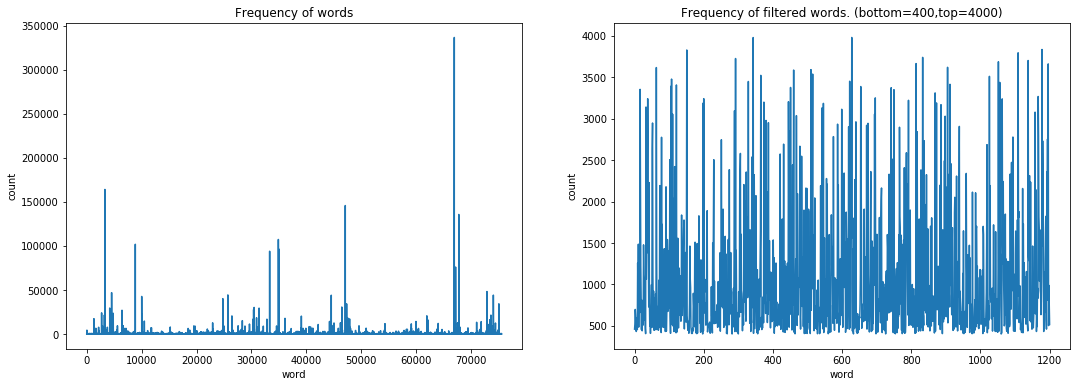

In [7]:
plt.figure(figsize=(18,6))
# figure 1
plt.subplot(1, 2, 1)
plt.plot(counts)
plt.xlabel("word")
plt.ylabel("count")
plt.title("Frequency of words")
print("features", len(counts), "mean", counts.mean(), "median", np.median(counts))

# figure 2
plt.subplot(1, 2, 2)
top = 4000
bottom = 400
counts_filtered_top = counts[counts<top]
counts_filtered = counts_filtered_top[counts_filtered_top>bottom]
print("features", len(counts_filtered), "mean", counts_filtered.mean(), "median", np.median(counts_filtered))
plt.plot(counts_filtered)
plt.xlabel("word")
plt.ylabel("count")
plt.title("Frequency of filtered words. (bottom={},top={})".format(bottom, top))

# possible values for min 3, 50, 100, 400
# possible values for max 400, 4000, 40000

{'whiskers': [<matplotlib.lines.Line2D at 0x28fdaeb7da0>,
 'caps': [<matplotlib.lines.Line2D at 0x28fdaec1748>,
 'boxes': [<matplotlib.lines.Line2D at 0x28fdaeb7c50>,
 'medians': [<matplotlib.lines.Line2D at 0x28fdaec1dd8>,
 'fliers': [],
 'means': []}

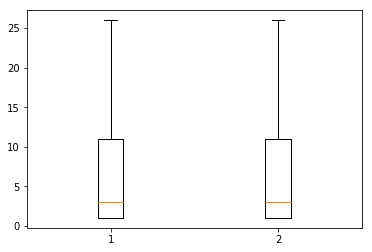

In [8]:
data = [counts, counts_filtered_top]
plt.boxplot(data, showfliers=False)

C:\Users\Public\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


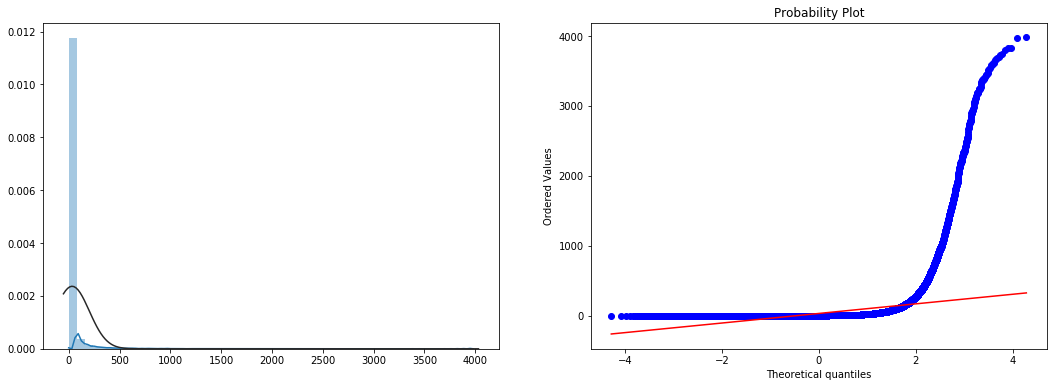

In [9]:
plt.figure(figsize=(18,6))  # follows a normal distribution? 
plt.subplot(1,2,1)

sns.distplot(counts_filtered_top, fit=norm) 
plt.subplot(1,2,2)
res = stats.probplot(counts_filtered_top, plot=plt)

# Feature Engineering

In [10]:
score = 'f1'

In [11]:
pca = PCA()

## Logistic Regression

Feature engineering considering TF-IDF

In [ ]:
parameters_regression_tfidf = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_tfidf = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='saga', penalty='l2'))
])
                  
rs_regression_tfidf = RandomizedSearchCV(pipeline_regression_tfidf, parameters_regression_tfidf, 
                                   cv=10, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20, 
                                         return_train_score=True)
start = time.time()
rs_regression_tfidf.fit(X_train, y)
time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_

In [ ]:
pd.options.display.max_columns = None
pd.DataFrame(rs_regression_tfidf.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

Feature engineering BoW

In [ ]:
parameters_regression_bow = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [400, 4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_bow = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=200))
])
                  
rs_regression_bow = RandomizedSearchCV(pipeline_regression_bow, parameters_regression_bow, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20,
                                      return_train_score=True)
start = time.time()
rs_regression_bow.fit(X_train, y)
time.time() - start, rs_regression_bow.best_params_, rs_regression_bow.best_score_

In [ ]:
pd.DataFrame(rs_regression_bow.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

In [ ]:
parameters_regression_bin = {
#     'vec__stem': [True, False],
#     'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_bin = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=True, max_df=400, min_df=3,
                                ngram_range=(1,2), stem=True)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', fit_intercept=True, max_iter=1000))
])
                  
rs_regression_bin = GridSearchCV(pipeline_regression_bin, parameters_regression_bin, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, return_train_score=True)
                            #, random_state=62, n_iter=20)
start = time.time()
rs_regression_bin.fit(X_train, y)
time.time() - start, rs_regression_bin.best_params_, rs_regression_bin.best_score_

In [ ]:
pd.DataFrame(rs_regression_bin.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

## Multinomial Naive Bayes

Feature engineering considering BoW

In [ ]:
parameters_mnv_bow = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 2), (2, 2)],
    'clf__alpha': [.5, .1, 2, 3], 
}

pipeline_mnv_bow = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('clf', MultinomialNB())
])
                  
rs_mnv_bow = RandomizedSearchCV(pipeline_mnv_bow, parameters_mnv_bow, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20
                               , return_train_score=True)
start = time.time()
rs_mnv_bow.fit(X_train, y)
time.time() - start, rs_mnv_bow.best_params_, rs_mnv_bow.best_score_

In [ ]:
pd.DataFrame(rs_mnv_bow.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

## Bernoulli Naive Bayes

Feature engineering, binary values

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [ ]:
params_bnv = {
    'clf__smooth': [.01, .1, 1, 2]
}

bnv = vect = LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=True, 
                                stem=True, ngram_range=(1, 2), min_df=250, max_df=4000)
X_train_bnv = bnv.fit_transform(X_train)

pipeline_bnv = Pipeline([
    ('clf', BernoulliNaiveBayes())
])

gs_bnv = GridSearchCV(pipeline_bnv, params_bnv, 
                                   cv=20, scoring=score, verbose=0, return_train_score=True)
start = time.time()
gs_bnv.fit(X_train_bnv.toarray(), y)

# scores = cross_val_score(bnv_clf, X_train_vect.toarray(), y, cv=20, scoring='f1', n_jobs=-1)
# time.time() - start, scores, scores.mean(), scores.std()
time.time() - start, gs_bnv.best_params_, gs_bnv.best_score_

In [ ]:
pd.DataFrame(gs_bnv.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

## Support Vector Machine

In [57]:
parameters_svm = {
    'vec__min_df': [300],
    'vec__max_df': [750],
    'vec__stem': [True, False],
    'vec__binary': [True, False],
    #'clf__degree': [2, 3, 4],
    #'clf__C': [.5, 1.0, 2.5, 3], 
    #'pca__n_components': [4000, 5000, 6000]
}

pipeline_svm = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, ngram_range=(1,1), 
                                 stem=True, binary=False)),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,))
    #('pca', pca),
    #('clf', SVC(random_state=0, tol=1e-5, gamma='scale'))
])

tfidf_X_train = pipeline_svm.fit_transform(X_train)
pca = PCA(n_components=500)
print(tfidf_X_train.shape)
pca_X_train = pca.fit(tfidf_X_train.toarray())

#clf = SVC(random_state=0, tol=1e-5, gamma='scale')
#clf_X_train = clf.fit(pca_X_train)

pipeline_clf = Pipeline([
    ('clf', SVC(random_state=0, tol=1e-5, gamma='scale'))
])
parameters_clf = {
    'clf__degree': [2, 3, 4],
    'clf__C': [.5, 1.0, 2.5, 3], 
}
                  
rs_svm = RandomizedSearchCV(pipeline_clf, parameters_clf, 
                                   cv=2, scoring=score, n_jobs=-1, verbose=1000, random_state=62, n_iter=2, 
                                         return_train_score=True)
start = time.time()
rs_svm.fit(pca_X_train, y)
time.time() - start, rs_svm.best_params_, rs_svm.best_score_

(25000, 75589)


MemoryError: 

## Decision Trees

In [18]:
parameters_tree = {
    'vec__min_df': [3, 50, 100, 400],
    'vec__max_df': [4000, 40000],
    'vec__stem': [True],
    'vec__ngram_range':[(1, 2), (2, 2)],
    'clf__max_depth': [300, 500, 700],
    'clf__min_samples_split': [1, 2, 5],
    'clf__min_samples_leaf': [1, 2, 5]
}

pipeline_tree = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('clf', DecisionTreeClassifier())
])
                  
rs_tree = RandomizedSearchCV(pipeline_tree, parameters_tree, 
                                   cv=10, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=1
                               , return_train_score=True)
start = time.time()
rs_tree.fit(X_train, y)

time.time() - start, rs_tree.best_params_, rs_tree.best_score_

(447.94632744789124,
 {'vec__stem': True,
  'vec__ngram_range': (1, 2),
  'vec__min_df': 50,
  'vec__max_df': 4000,
  'clf__min_samples_split': 2,
  'clf__min_samples_leaf': 1,
  'clf__max_depth': 300},
 0.7025585507455621)

# Model selection

In [12]:
#import importlib
import nlp_processing as nlp
#from nlp_processing import LemmaCountVectorizer
#importlib.reload(nlp_processing)
parameters_best_lr = {
    'clf__fit_intercept': [True], 
    'clf__C': [.5, .6, .7, .8], 
}

pipeline_best_lr = Pipeline([
    ('vec', nlp.LemmaCountVectorizer(strip_accents='unicode', stop_words=None, min_df=3, max_df=400, 
                                 stem=True, ngram_range=(1, 2), preprocessing=True)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=200, fit_intercept=True))
])
                  
rs_best_lr = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=50,
                                      return_train_score=True)
start = time.time()
rs_best_lr.fit(X_train, y)
time.time() - start, rs_best_lr.best_params_, rs_best_lr.best_score_

Fitting 15 folds for each of 4 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 15.

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(3497.8175959587097,
 {'clf__C': 0.5, 'clf__fit_intercept': True},
 0.8653639518378007)

# Best Model

In [14]:
X_train = train.iloc[:,1].values
X_test = test.iloc[:,1].values
y = train.iloc[:,2].values.astype(int)
# select best model
model = rs_best_lr.best_estimator_
model

Pipeline(memory=None,
     steps=[('vec', LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=400, max_features=None, min_df=3,
           ngram_range=(1, 2), preprocessing=True, preprocessor=Non...penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

# Submission

In [ ]:
y_pred = model.predict(X_test)
test['Category'] = y_pred

# submission results
submission = test.drop(columns='Text')
submission.to_csv('../data/submission.csv', index=False)